# **Time Series Analysis** 

Data can be categorized into two types based on how and when they are collected: Time Series Data and Cross-Sectional Data. The term time series data refers to data that is collected at regular intervals over time (e.g., daily, monthly, yearly). Cross-Sectional data, on the other hand, is collected from different individuals, groups, or entities at a specific point in time. To put it another way, time series data shows how things change over time, while cross-sectional data shows how things were at a certain point in time across many people or places.


When we take time series data and use them to predict future values based on time-bound attributes, it is called **forecasting**. Further, using historical, aka time series data, to estimate future values is the process of forecasting. It takes into account the sequential nature of data where each observation is dependent on previous observations.

Time series analysis is a useful tool that can help us find unusual things in data. It can detect when something strange or unexpected happens, like errors or unusual events. This is important because it allows us to catch fraud, keep an eye on how well a system is working, or notice when something is behaving strangely. Time series analysis helps us find these abnormal behaviors in different situations and applications.



Some key characteristics of time series data include:

- Temporal Ordering: Time series data is ordered chronologically, with each observation occurring after the previous one. This ordering is essential for analyzing trends and patterns.
- Time Dependency: In a time series, each observation is influenced by the preceding observations, creating a sequential relationship where the value at a given time depends on the values that occurred before it.
- Irregular Sampling: Analyzing and forecasting time series data can be challenging when there are irregular or uneven time intervals between observations. Dealing with missing or irregularly spaced data points necessitates the use of suitable techniques.

In [99]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [100]:
dj_df = sns.load_dataset("dowjones")
dj_df.head()

,Date,Price
0,1914-12-01,55.00
1,1915-01-01,56.55
2,1915-02-01,56.00
3,1915-03-01,58.30
4,1915-04-01,66.45


In [101]:
is_chronological = dj_df["Date"].is_monotonic_increasing
print("Is dj_df ordered chronologically?", is_chronological)

Is dj_df ordered chronologically? True


In [102]:
average_frequency = pd.infer_freq(dj_df["Date"])
print("Average Frequency:", average_frequency)

Average Frequency: MS


| Frequency String | Meaning |
|---|---|
| `'D'` | Daily (e.g., 2024-01-01, 2024-01-02, ...) |
| `'B'` | Business Days (Weekdays only, excludes weekends) |
| `'W-MON'` | Weekly, starting on Monday |
| `'W-SUN'` | Weekly, starting on Sunday |
| `'M'` | Month-end (Last calendar day of the month) |
| `'MS'` | Month-start (First calendar day of the month) |
| `'Q-DEC'` | Quarterly, ending in December |
| `'Q-JAN'` | Quarterly, ending in January |
| `'A-DEC'` | Annual, ending in December |
| `'A-MAR'` | Annual, ending in March |
| `'H'` | Hourly |
| `'T'` | Minute-level (Also known as `'min'`) |
| `'S'` | Second-level |
| `'L'` | Millisecond-level |
| `'U'` | Microsecond-level |
| `'N'` | Nanosecond-level |

In [103]:
# Create a complete date range based on the average frequency
full_date_range = pd.date_range(
    start=dj_df["Date"].min(), end=dj_df["Date"].max(), freq=average_frequency
)

# Reindex the DataFrame to include all dates in the range
dj_df = dj_df.set_index("Date").reindex(full_date_range).rename_axis("Date").reset_index()

# Forward fill the missing values
dj_df["Price"] = dj_df["Price"].ffill()

dj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    649 non-null    datetime64[ns]
 1   Price   649 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.3 KB


## **Components**

We can break down time series data into three primary components, which aid in comprehending the underlying patterns:

1. **Trend**: This represents the long-term direction or tendency of the data. It captures the overall upward or downward movement over time. Trends can be linear (constant increase or decrease) or nonlinear (curved or oscillating).
2. **Seasonality**: Refers to patterns that repeat at fixed intervals within a time series. These patterns can be daily, weekly, monthly, or yearly. External factors such as weather conditions, holidays, or economic cycles often have an impact on seasonality.
3. **Noise(random fluctuations/ irregularities)** : Represents the unpredictable and random variations in the data and includes factors that cannot be explained by trend or seasonality. Measurement errors, random events, or unidentified factors can contribute to the presence of noise in the data.

By decomposing data into these three components, we try to understand our data’s nature and optimize the forecasted values to be more aligned with real values.

By isolating the trend, we can understand the long-term movement and make better long-term forecasts. With seasonality, we understand short-term variations and predict cyclical events. Finally, understanding the residual increases our model’s accuracy by focusing on the predictable parts (trend and seasonality) and acknowledging uncertainty.

In [104]:
dowjones_df = dj_df.copy()
dowjones_df.set_index("Date", inplace=True)

The `seasonal_decompose` function in statsmodels is used for time series decomposition, which breaks down a time series into three main components:

- Trend → The long-term pattern in the data.
- Seasonality → Repeating patterns at a fixed frequency.
- Residual (Noise) → The random variations after removing trend and seasonality.

Uses either additive or multiplicative decomposition.

- Additive Model (Used when trend & seasonality are constant over time). Example: Temperature changes, where daily fluctuations remain roughly the same. 
- Multiplicative Model (Used when trend & seasonality vary proportionally. Example: Retail sales, where seasonal effects increase with higher overall sales.

### **statsmodels.tsa.seasonal.seasonal_decompose**

In [105]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series using the additive method
decomposition = seasonal_decompose(x=dowjones_df[["Price"]], model="additive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create a subplot for the decomposition components
fig = make_subplots(
    rows=4,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=(
        "<b>Original Data</b>",
        "<b>Trend</b>",
        "<b>Seasonality</b>",
        "<b>Residuals</b>",
    ),
)

# Original data
fig.add_trace(
    go.Scatter(
        x=dowjones_df.index,
        y=dowjones_df["Price"],
        mode="lines",
        name="Original",
        line=dict(color="blue"),
    ),
    row=1,
    col=1,
)

# Trend
fig.add_trace(
    go.Scatter(
        x=dowjones_df.index, y=trend, mode="lines", name="Trend", line=dict(color="orange")
    ),
    row=2,
    col=1,
)

# Seasonal
fig.add_trace(
    go.Scatter(
        x=dowjones_df.index, y=seasonal, mode="lines", name="Seasonality", line=dict(color="green")
    ),
    row=3,
    col=1,
)

# Residuals
fig.add_trace(
    go.Scatter(
        x=dowjones_df.index, y=residual, mode="lines", name="Residuals", line=dict(color="red")
    ),
    row=4,
    col=1,
)

# Update the layout for better visuals
fig.update_layout(
    title={
        "text": "<b>Decomposition of Time Series</b>",
        "x": 0.5,
        "xanchor": "center",
    },  # Center and bold title
    height=2050,
    width=900,  # Adjust dimensions
    showlegend=False,  # Disable legends for individual subplots
    template="plotly_white",
    xaxis_showgrid=True,
    yaxis_showgrid=True,
    hovermode="x unified",
)

# Update x-axis for all subplots
fig.update_xaxes(title_text="Month", showgrid=True)

# Update y-axes titles
fig.update_yaxes(title_text="<b>Price</b>", row=1, col=1)
fig.update_yaxes(title_text="<b>Trend</b>", row=2, col=1)
fig.update_yaxes(title_text="<b>Seasonality</b>", row=3, col=1)
fig.update_yaxes(title_text="<b>Residuals</b>", row=4, col=1)

# Show plot
fig.show()

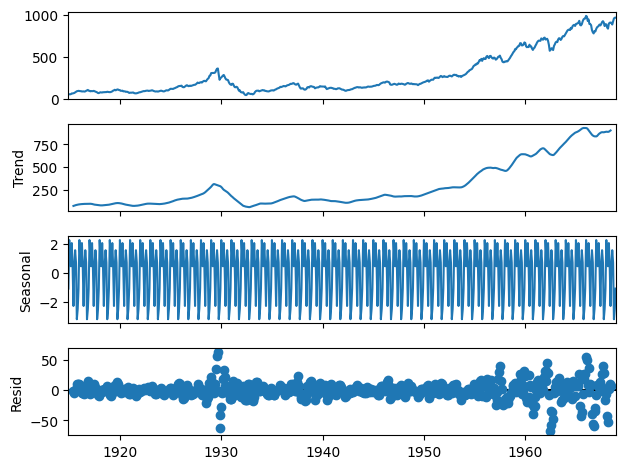

In [106]:
# View the decomposed components
decomposition.plot()
plt.show()

## **Stationarity**

Stationarity is a fundamental concept in time series analysis. Stationarity refers to the condition where the statistical properties of a time series, such as its mean, variance, and autocorrelation, remain consistent over time. Stationary time series data typically displays consistent patterns, which simplifies the process of forecasting future values. Models developed using stationary data are known to offer more dependable and precise predictions.

In practical terms, making time series data stationary may involve making changes or using techniques to eliminate trends or seasonality. Stationarity is an important factor to consider when working with time series data to ensure accurate analysis and dependable forecasts.

### **Augmented Dickey-Fuller (ADF) Test**

The ADF test is the most popular statistical test. It is done with the following assumptions:
- Null Hypothesis ($H_0$): Series is non-stationary
- Alternate Hypothesis ($H_1$): Series is stationary


The ADF test returns:
- ADF Statistic → More negative values suggest stronger stationarity.
- p-value → If p < 0.05, reject H₀ (i.e., series is stationary).
- Critical Values → Thresholds for significance at 1%, 5%, and 10%.

 It is commonly used before applying ARIMA or other time series models.

`d`: The degree of differencing needed to make the series stationary (use d=0 for stationary series).

In [107]:
from statsmodels.tsa.stattools import adfuller

#  Augmented Dickey-Fuller test function


def adfuller_test(passengers):
    result = adfuller(passengers)
    labels = ["ADF Test Statistic", "p-value", "#Lags Used", "Number of Observations"]
    for value, label in zip(result, labels):
        print(label + " : " + str(value))

    if result[1] <= 0.05:
        print("\n---- Test Result -----")

        print(
            "Strong evidence against the null hypothesis(H0), so reject the null hypothesis. Say data is stationary"
        )
        print("Good to go for ARIMA")
    else:
        print("\n---- Test Result -----")
        print("Weak evidence against null hypothesis, indicating it is non-stationary. ")
        print("Non Stationary so need for differencing")


adfuller_test(dowjones_df["Price"])  # function calling for ADF function

ADF Test Statistic : 1.4073766540721009
p-value : 0.9971473965549805
#Lags Used : 10
Number of Observations : 638

---- Test Result -----
Weak evidence against null hypothesis, indicating it is non-stationary. 
Non Stationary so need for differencing


The ADF test may not detect all stationarity types (e.g., seasonal stationarity). Let’s discuss quickly how to convert non-stationary to stationary for effective time series modeling. There are three methods available for this conversion – detrending, differencing, and transformation.

### **Differencing**

This is a simple transformation of the series into a new time series, which we use to remove the series dependence on time and stabilize the mean of the time series, so trend and seasonality are reduced during this transformation. Differencing means subtracting each value from its preceding value (also called lags) in the time series.


We should lag it by the first difference and the seasonal difference.

In [108]:
# Perform differencing on the 'Price' column
for i in [1, 12]:
    dowjones_df[f"Price_diff_{i}"] = dowjones_df["Price"].diff(periods=i)

# Display the first few rows to verify
dowjones_df.head(10)

,Price,Price_diff_1,Price_diff_12
Date,,,
1914-12-01,55.00,NaN,NaN
1915-01-01,56.55,1.55,NaN
1915-02-01,56.00,-0.55,NaN
1915-03-01,58.30,2.30,NaN
1915-04-01,66.45,8.15,NaN
1915-05-01,65.95,-0.50,NaN
1915-06-01,68.40,2.45,NaN
1915-07-01,71.85,3.45,NaN
1915-08-01,79.25,7.40,NaN


We will then use the Adfuller test to see after the first, second ... etc. difference, if the data is stationary or not.

In [109]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(dowjones_df["Price_diff_1"].dropna())

ADF Test Statistic : -8.289917116891464
p-value : 4.289280229523169e-13
#Lags Used : 9
Number of Observations : 638

---- Test Result -----
Strong evidence against the null hypothesis(H0), so reject the null hypothesis. Say data is stationary
Good to go for ARIMA


In [110]:
# Create an interactive line plot with Plotly for 'Seasonal First Difference'
fig = go.Figure()

# Add a line trace for the seasonal first difference
fig.add_trace(
    go.Scatter(
        x=dowjones_df.index,
        y=dowjones_df["Price_diff_1"],
        mode="lines",
        name="First Difference",
        line=dict(color="purple"),
    )
)

# Customize the layout for better visualization
fig.update_layout(
    title="First Difference of Dowjones",
    xaxis_title="Month",
    yaxis_title="First Difference",
    template="plotly_white",
    width=900,
    height=500,  # Custom dimensions
    xaxis=dict(showgrid=True, zeroline=False),
    yaxis=dict(showgrid=True, zeroline=False),
    hovermode="x unified",  # Show hover info for all traces at the same time
)

In [111]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(dowjones_df["Price_diff_12"].dropna())

ADF Test Statistic : -5.399346921001534
p-value : 3.3979185288464557e-06
#Lags Used : 17
Number of Observations : 619

---- Test Result -----
Strong evidence against the null hypothesis(H0), so reject the null hypothesis. Say data is stationary
Good to go for ARIMA


In [112]:
# Create an interactive line plot with Plotly for 'Seasonal First Difference'
fig = go.Figure()

# Add a line trace for the seasonal first difference
fig.add_trace(
    go.Scatter(
        x=dowjones_df.index,
        y=dowjones_df["Price_diff_12"],
        mode="lines",
        name="Seasonal First Difference",
        line=dict(color="purple"),
    )
)

# Customize the layout for better visualization
fig.update_layout(
    title="Seasonal First Difference of Dowjones",
    xaxis_title="Month",
    yaxis_title="Seasonal First Difference",
    template="plotly_white",
    width=900,
    height=500,  # Custom dimensions
    xaxis=dict(showgrid=True, zeroline=False),
    yaxis=dict(showgrid=True, zeroline=False),
    hovermode="x unified",  # Show hover info for all traces at the same time
)

Now the data is stationary. Here, we should note that, if on doing the first difference, we do not get stationary, we further perform differencing called double differencing, till we get stationary data. So in our case, the `d` component is 1.

### **Detrending**

It involves removing the trend effects from the given dataset and showing only the differences in values from the trend. It always allows cyclical patterns to be identified. Using a polynomial or linear regression to estimate the trend and subtract it.


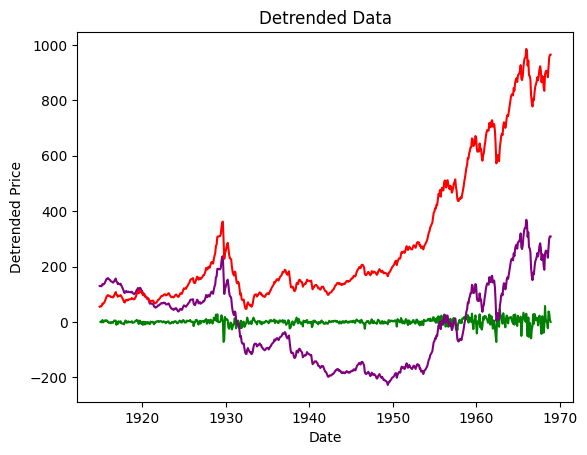

In [113]:
from matplotlib import pyplot as plt
from scipy.signal import detrend

# Detrending the data using the mean
dowjones_df["Price_detrend"] = detrend(dowjones_df["Price"], type="linear")  # Removes linear trend
dowjones_df["Price_detrend_diff"] = dowjones_df["Price_detrend"].diff(periods=1)
# Plotting the detrended data
sns.lineplot(x=dowjones_df.index, y=dowjones_df["Price_detrend_diff"], color="green")
sns.lineplot(x=dowjones_df.index, y=dowjones_df["Price_detrend"], color="purple")
sns.lineplot(x=dowjones_df.index, y=dowjones_df["Price"], color="red")
plt.title("Detrended Data")
plt.xlabel("Date")
plt.ylabel("Detrended Price")
plt.show()

In [114]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(dowjones_df["Price_detrend"].dropna())

ADF Test Statistic : -0.6943347101138664
p-value : 0.8482115232505798
#Lags Used : 10
Number of Observations : 638

---- Test Result -----
Weak evidence against null hypothesis, indicating it is non-stationary. 
Non Stationary so need for differencing


In [115]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(dowjones_df["Price_detrend_diff"].dropna())

ADF Test Statistic : -8.289917116891452
p-value : 4.2892802295234326e-13
#Lags Used : 9
Number of Observations : 638

---- Test Result -----
Strong evidence against the null hypothesis(H0), so reject the null hypothesis. Say data is stationary
Good to go for ARIMA


In [116]:
# Create an interactive line plot with Plotly for 'Seasonal First Difference'
fig = go.Figure()

# Add a line trace for the seasonal first difference
fig.add_trace(
    go.Scatter(
        x=dowjones_df.index,
        y=dowjones_df["Price_detrend_diff"],
        mode="lines",
        name="First Difference Detrend",
        line=dict(color="purple"),
    )
)

# Customize the layout for better visualization
fig.update_layout(
    title="First Difference Detrend of Dowjones",
    xaxis_title="Month",
    yaxis_title="First Difference Detrend",
    template="plotly_white",
    width=900,
    height=500,  # Custom dimensions
    xaxis=dict(showgrid=True, zeroline=False),
    yaxis=dict(showgrid=True, zeroline=False),
    hovermode="x unified",  # Show hover info for all traces at the same time
)

If you detrend a time series before applying ARIMA, you are effectively removing the trend component, making the series more stationary. However, ARIMA inherently models trends through its differencing component (`d` in ARIMA(`p`,`d`,`q`)), so manually detrending might not always be necessary.

### **Transformation**

This includes three different methods they are Power Transform, Square Root, and Log Transfer. The most commonly used one is Log Transfer.

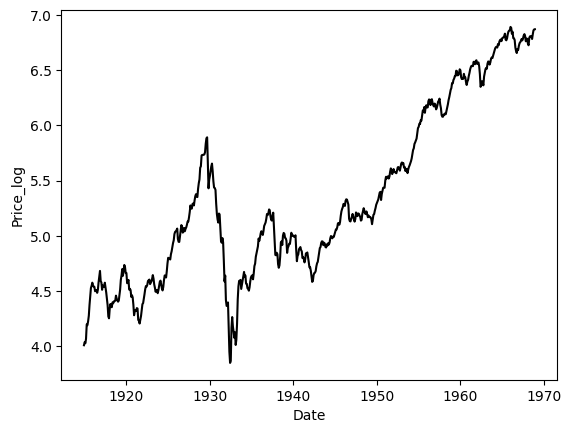

In [117]:
# Transform the data with logarithm
dowjones_df["Price_log"] = np.log(dowjones_df["Price"])
dowjones_df["Price_log_diff_1"] = dowjones_df["Price_log"].diff(periods=1)
dowjones_df["Price_sqrt"] = np.sqrt(dowjones_df["Price"])
dowjones_df["Price_sqrt_diff_1"] = dowjones_df["Price_sqrt"].diff(periods=1)

sns.lineplot(x="Date", y="Price_log", data=dowjones_df, color="black")
plt.show()

In [118]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(dowjones_df["Price_log"].dropna())

ADF Test Statistic : -0.7986977741761923
p-value : 0.8195042873621745
#Lags Used : 7
Number of Observations : 641

---- Test Result -----
Weak evidence against null hypothesis, indicating it is non-stationary. 
Non Stationary so need for differencing


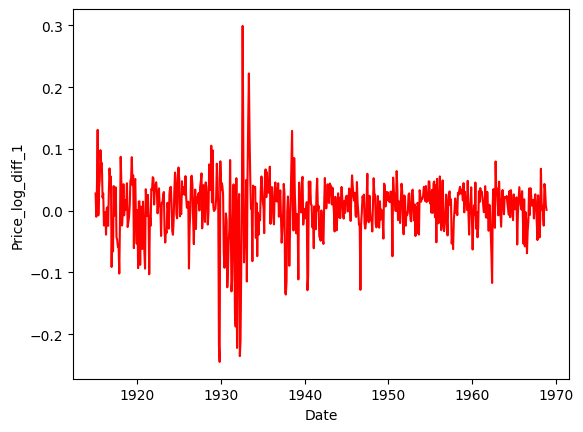

In [119]:
sns.lineplot(x="Date", y="Price_log_diff_1", data=dowjones_df, color="red")
plt.show()

In [120]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(dowjones_df["Price_log_diff_1"].dropna())

ADF Test Statistic : -7.6236904335039775
p-value : 2.0957782928018553e-11
#Lags Used : 6
Number of Observations : 641

---- Test Result -----
Strong evidence against the null hypothesis(H0), so reject the null hypothesis. Say data is stationary
Good to go for ARIMA


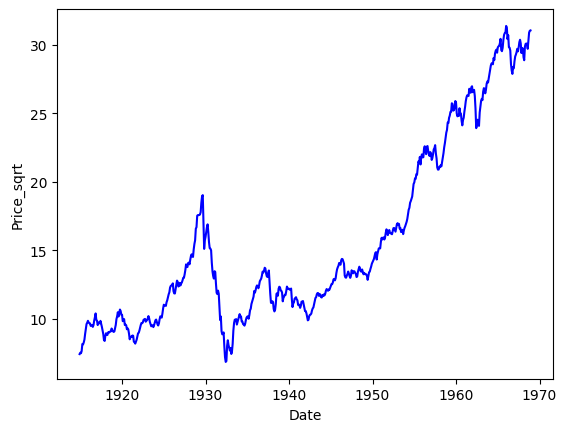

In [121]:
sns.lineplot(x="Date", y="Price_sqrt", data=dowjones_df, color="blue")
plt.show()

In [122]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(dowjones_df["Price_sqrt"].dropna())

ADF Test Statistic : 0.44567738769209825
p-value : 0.9831250532305473
#Lags Used : 2
Number of Observations : 646

---- Test Result -----
Weak evidence against null hypothesis, indicating it is non-stationary. 
Non Stationary so need for differencing


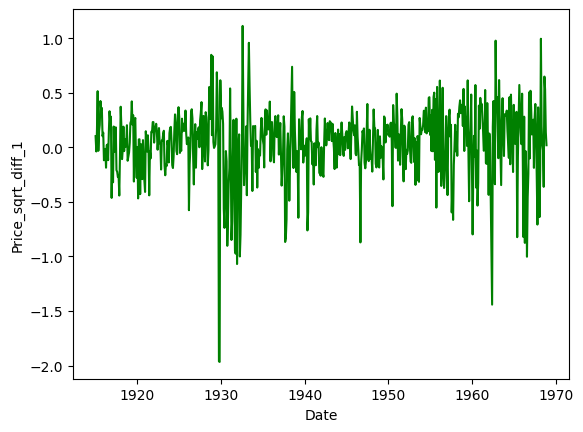

In [123]:
sns.lineplot(x="Date", y="Price_sqrt_diff_1", data=dowjones_df, color="green")
plt.show()

In [124]:
# Again testing if data is stationary- we need to just call the adfuller_test function
adfuller_test(dowjones_df["Price_sqrt_diff_1"].dropna())

ADF Test Statistic : -16.487146224926587
p-value : 2.2095651344522411e-29
#Lags Used : 1
Number of Observations : 646

---- Test Result -----
Strong evidence against the null hypothesis(H0), so reject the null hypothesis. Say data is stationary
Good to go for ARIMA


## **Trend Analysis**

The Moving Average process is inherently stationary because it models the series based on past errors, which have zero mean and constant variance. The Moving Average (MA) (or) Rolling Mean: The value of MA is calculated by taking average data of the time-series within k periods. These models are not typically used for forecasting in the same way as ARIMA or other predictive models.

They are helpful for getting a big-picture view of your data during EDA, showing the overall trend without being overly sensitive to short-term fluctuations. It can be useful to check for outliers, as large deviations from the CMA could suggest unusual events or anomalies.


### **Simple Moving Average (SMA)**

The Simple Moving Average (SMA) calculates the unweighted mean of the previous M or N points. We prefer selecting sliding window data points based on the amount of smoothing, as increasing the value of M or N improves smoothing but reduces accuracy.


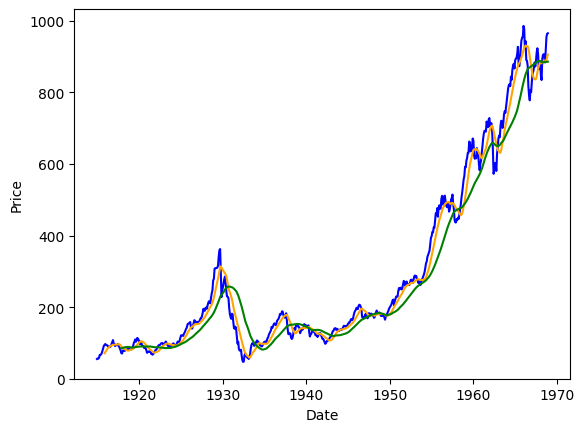

In [125]:
# SMA over a period of 10 and 20 years
dowjones_df["SMA_12M"] = dowjones_df.Price.rolling(12).mean()
dowjones_df["SMA_36M"] = dowjones_df.Price.rolling(36).mean()


# Line plot
sns.lineplot(data=dowjones_df, x="Date", y="Price", color="blue")
sns.lineplot(data=dowjones_df, x="Date", y="SMA_12M", color="orange")
sns.lineplot(data=dowjones_df, x="Date", y="SMA_36M", color="green")
plt.show()

### **Cumulative Moving Average (CMA)**

The CMA is the unweighted mean of past values till the current time.


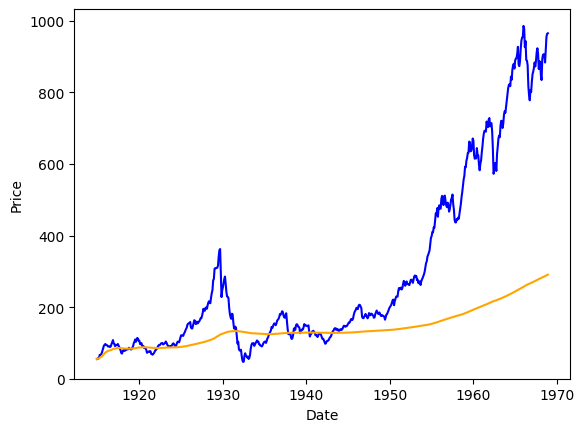

In [126]:
dowjones_df["CMA"] = dowjones_df.Price.expanding().mean()

sns.lineplot(data=dowjones_df, x="Date", y="Price", color="blue")
sns.lineplot(data=dowjones_df, x="Date", y="CMA", color="orange")
plt.show()

### **Exponential Moving Average (EMA)**

EMA is mainly used to identify trends and filter out noise. The weight of elements is decreased gradually over time. This means It gives weight to recent data points, not historical ones. The EMA is more sensitive to recent changes compared to the CMA and reacts more quickly to the latest data. This makes it useful for short-term trend analysis.

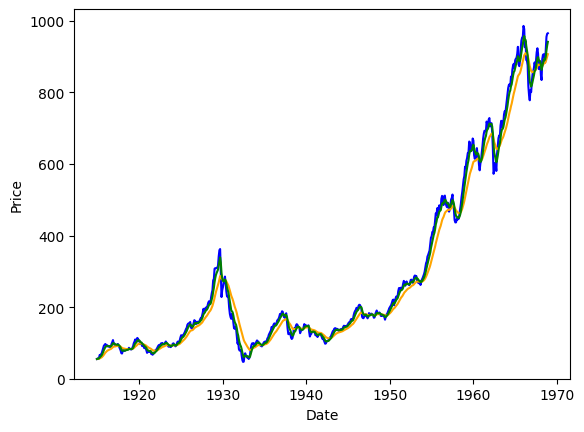

In [127]:
# Smoothing factor 0.1
dowjones_df["EMA_0.1"] = dowjones_df.Price.ewm(alpha=0.1, adjust=False).mean()
# Smoothing factor 0.3
dowjones_df["EMA_0.3"] = dowjones_df.Price.ewm(alpha=0.3, adjust=False).mean()

sns.lineplot(data=dowjones_df, x="Date", y="Price", color="blue")
sns.lineplot(data=dowjones_df, x="Date", y="EMA_0.1", color="orange")
sns.lineplot(data=dowjones_df, x="Date", y="EMA_0.3", color="green")
plt.show()

## **Lag Analysis**

In time series forecasting, a lag is simply a past value of the series. For example, for daily series, the first lag refers to the value the series had the previous day, the second to the value of the day before and so on.

Lag analysis is based on computing correlations between the series and a lagged version of the series itself, this is also called autocorrelation.



### **ACF**

The autocorrelation coefficients make up the autocorrelation function (ACF) for the series, this is simply a plot depicting the auto-correlation coefficient versus the number of lags taken into consideration.

When data has a trend, the autocorrelations for small lags are usually large and positive because observations close in time are also nearby in value. When data show seasonality, autocorrelation values will be larger in correspondence of seasonal lags (and multiples of the seasonal period) than for other lags. Data with both trend and seasonality will show a combination of these effects.


In [128]:
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf

# Number of observations
N = len(dowjones_df["Price_diff_1"].dropna())

# Calculate ACF and PACF values
acf_values, acf_confint = acf(
    dowjones_df["Price_diff_1"].dropna(), nlags=40, alpha=0.05
)  # 95% CI for ACF
pacf_values, pacf_confint = pacf(
    dowjones_df["Price_diff_1"].dropna(), nlags=40, alpha=0.05
)  # 95% CI for PACF

# Create subplots for ACF and PACF
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.15,
    subplot_titles=("<b>ACF Plot</b>", "<b>PACF Plot</b>"),
)

# ACF Plot with confidence intervals
fig.add_trace(
    go.Bar(x=list(range(len(acf_values))), y=acf_values, marker_color="blue", name="ACF"),
    row=1,
    col=1,
)

# Add confidence intervals as filled areas
fig.add_trace(
    go.Scatter(
        x=list(range(len(acf_values))),
        y=acf_confint[:, 0],
        mode="lines",
        line=dict(color="gray"),
        name="ACF Lower CI",
        showlegend=False,
        fill=None,
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(acf_values))),
        y=acf_confint[:, 1],
        mode="lines",
        line=dict(color="gray"),
        name="ACF Upper CI",
        showlegend=False,
        fill="tonexty",
        fillcolor="rgba(100, 100, 200, 0.2)",
    ),
    row=1,
    col=1,
)

# PACF Plot with confidence intervals
fig.add_trace(
    go.Bar(x=list(range(len(pacf_values))), y=pacf_values, marker_color="red", name="PACF"),
    row=2,
    col=1,
)

# Add confidence intervals as filled areas for PACF
fig.add_trace(
    go.Scatter(
        x=list(range(len(pacf_values))),
        y=pacf_confint[:, 0],
        mode="lines",
        line=dict(color="gray"),
        name="PACF Lower CI",
        showlegend=False,
        fill=None,
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(pacf_values))),
        y=pacf_confint[:, 1],
        mode="lines",
        line=dict(color="gray"),
        name="PACF Upper CI",
        showlegend=False,
        fill="tonexty",
        fillcolor="rgba(200, 100, 100, 0.2)",
    ),
    row=2,
    col=1,
)

# Update layout
fig.update_layout(
    height=700,
    width=900,
    title_text="<b>ACF and PACF Plots with Confidence Intervals</b>",
    title_x=0.5,
    showlegend=False,
    template="plotly_white",
)

# Update x-axis and y-axis labels
fig.update_xaxes(title_text="Lags", row=1, col=1)
fig.update_xaxes(title_text="Lags", row=2, col=1)
fig.update_yaxes(title_text="ACF", row=1, col=1)
fig.update_yaxes(title_text="PACF", row=2, col=1)

# Show the plot
fig.show()

If your series is non-stationary, you take the first difference (subtracting each data point from the previous one). You then check the ACF and PACF of this first differenced series. If the first difference doesn't make the series stationary, you can apply the second difference and repeat the process.


`q`: The order of the Moving Average (MA) component, determined by the ACF.

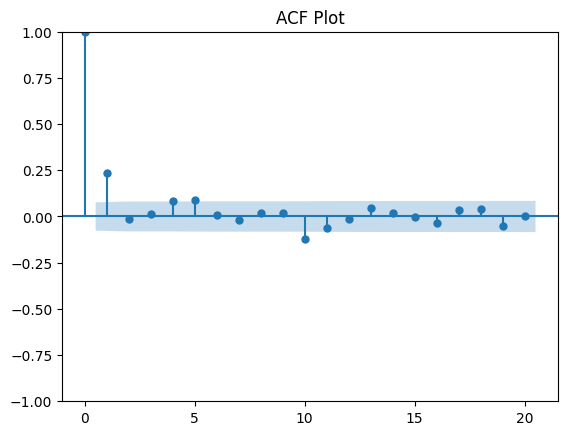

In [129]:
plot_acf(dowjones_df.Price_diff_1.fillna(0), lags=20)
plt.title("ACF Plot")
plt.show()

Look for the last significant lag in the ACF plot before it drops to near zero or becomes insignificant. If ACF shows significant spikes at lags 1 and 3 but not after, $q=3$.

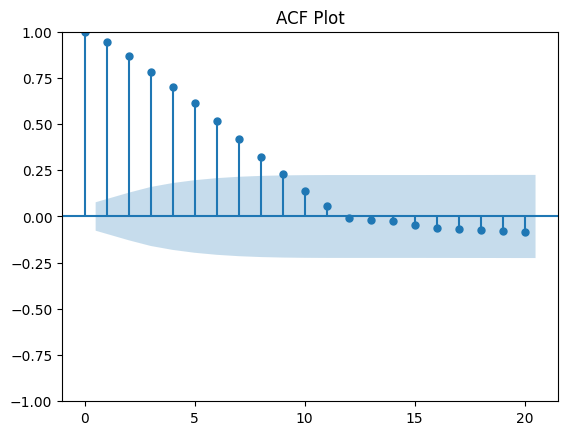

In [130]:
plot_acf(dowjones_df.Price_diff_12.fillna(0), lags=20)
plt.title("ACF Plot")
plt.show()


### **PACF**

In practice, a more useful function is the partial autocorrelation function (PACF). It is similar to the ACF, except that it shows only the direct autocorrelation between two lags. For example, the partial autocorrelation for lag 3 refers to the only correlation lag 1 and 2 do not explain. In other words, the partial correlation refers to the direct effect a certain lag has on the current time value.


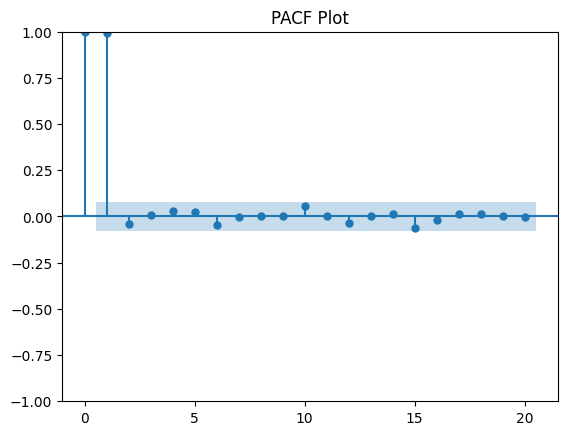

In [131]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dowjones_df.Price, lags=20)
plt.title("PACF Plot")
plt.show()

Before moving to the Python code, it is important to highlight that autocorrelation coefficient emerges more clearly if the series is stationary, so often is better to first differentiate the series to stabilize the signal.

`p`: The order of the Autoregressive (AR) component, determined by the PACF.

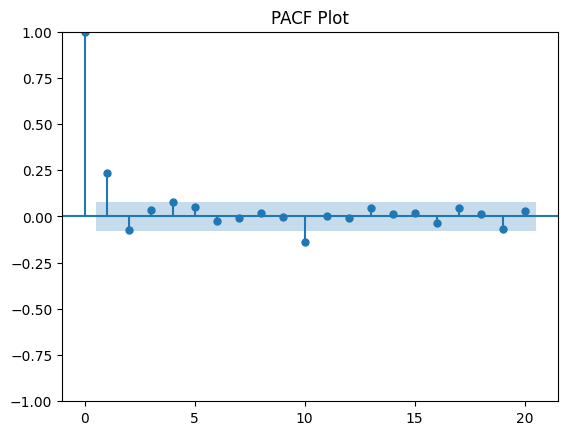

In [132]:
plot_pacf(dowjones_df.Price_diff_1.fillna(0), lags=20)
plt.title("PACF Plot")
plt.show()

Look for the last significant lag in the PACF plot before it drops to near zero or becomes insignificant. If PACF shows significant spikes at lags 1 and 2 but not after, $p=2$.

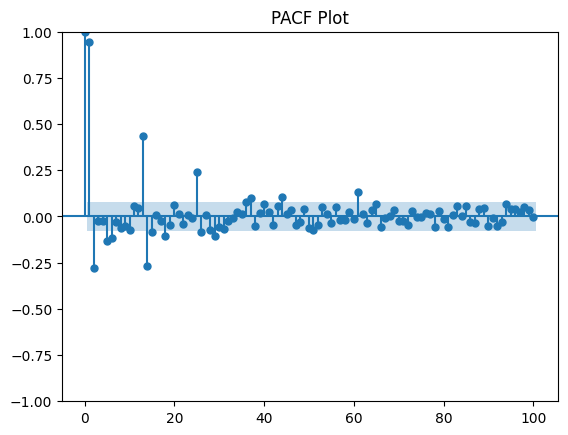

In [133]:
plot_pacf(dowjones_df.Price_diff_12.fillna(0), lags=100)
plt.title("PACF Plot")
plt.show()

## **Autoregressive Models**

An auto-regressive model is a simple model that predicts future performance based on past performance. It is mainly used for forecasting when there is some correlation between values in a given time series and those that precede and succeed (back and forth).

An AR is a Linear Regression model that uses lagged variables as input. By indicating the input, the Linear Regression model can be easily built using the `scikit-learn` library. `statsmodels` library provides autoregression model-specific functions where you must specify an appropriate lag value and train the model.

$Y_t = \alpha + \beta_1 Y_{t-1} + ... + \beta_p Y_{t-p}$

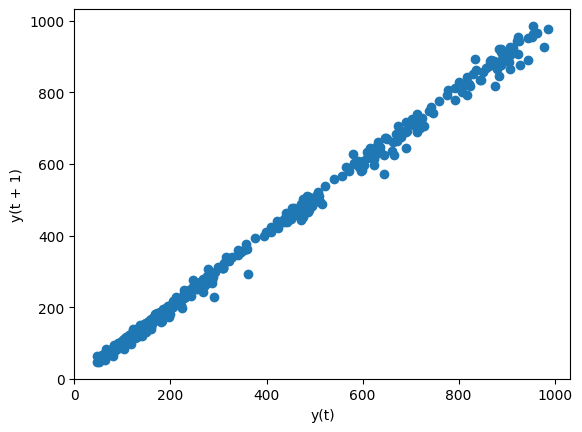

In [134]:
from pandas.plotting import lag_plot

lag_plot(dowjones_df.Price, lag=1)
plt.show()

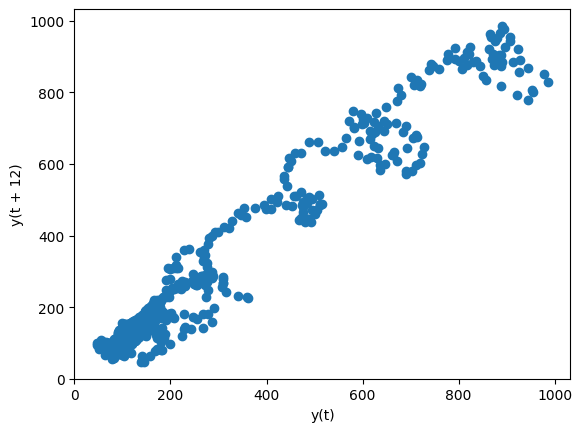

In [135]:
lag_plot(dowjones_df.Price, lag=12)
plt.show()

### **statsmodels.tsa.ar_model.AutoReg**

In [136]:
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

X = dowjones_df.Price_diff_1.fillna(0).values
y = dowjones_df.Price.values

# Split into train and test sets
X_train, X_test = X[: int(len(X) * 0.8)], X[int(len(X) * 0.8) :]
y_train, y_test = y[: int(len(y) * 0.8)], y[int(len(y) * 0.8) :]

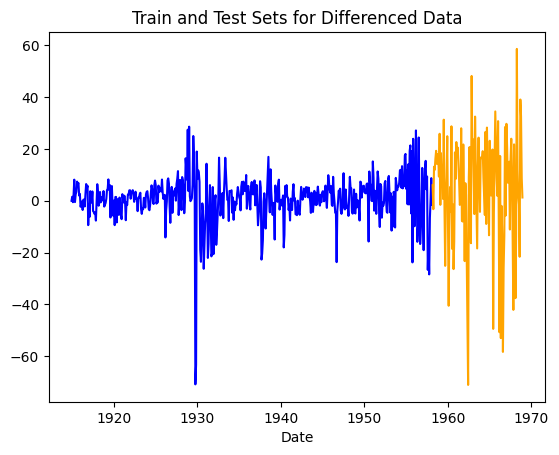

In [137]:
# Plot train and test sets
sns.lineplot(x=dowjones_df.index[: int(len(X) * 0.8)], y=X_train, color="blue")
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_test, color="orange")
plt.title("Train and Test Sets for Differenced Data")
plt.show()

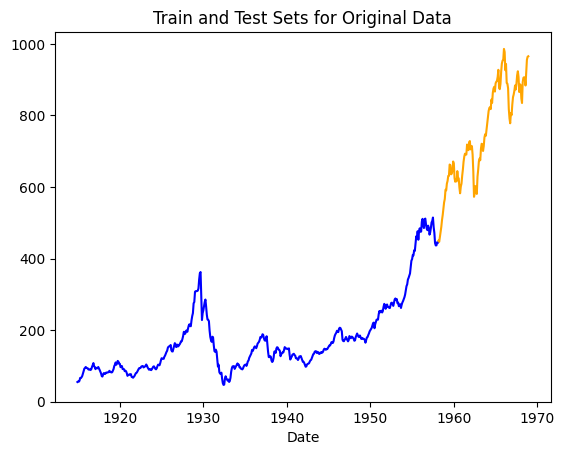

In [138]:
sns.lineplot(x=dowjones_df.index[: int(len(X) * 0.8)], y=y_train, color="blue")
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=y_test, color="orange")
plt.title("Train and Test Sets for Original Data")
plt.show()

In [139]:
# Train AR model using differenced data
model = AutoReg(X_train, lags=1)

In [140]:
# Fit model
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  519
Model:                     AutoReg(1)   Log Likelihood               -1831.786
Method:               Conditional MLE   S.D. of innovations              8.309
Date:                Fri, 04 Jul 2025   AIC                           3669.572
Time:                        13:50:04   BIC                           3682.322
Sample:                             1   HQIC                          3674.568
                                  519                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5118      0.366      1.397      0.162      -0.206       1.230
y.L1           0.3175      0.042      7.619      0.000       0.236       0.399
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1501           +0.0000j            3.1501            0.0000
-----------------------------------------------------------------------------
"""

In [141]:
# Predict on test set
X_pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)

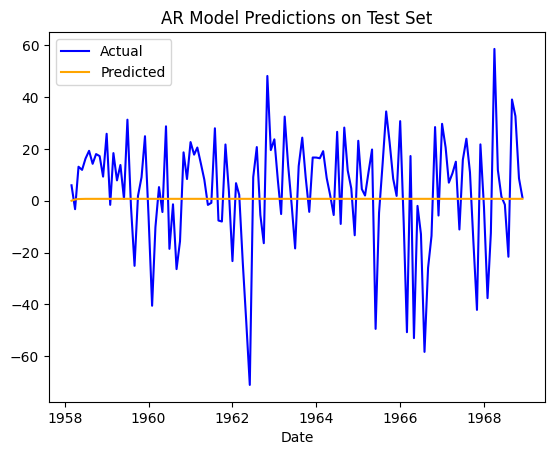

In [142]:
# Plot predictions
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_test, color="blue", label="Actual")
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_pred, color="orange", label="Predicted")
plt.title("AR Model Predictions on Test Set")
plt.legend()
plt.show()

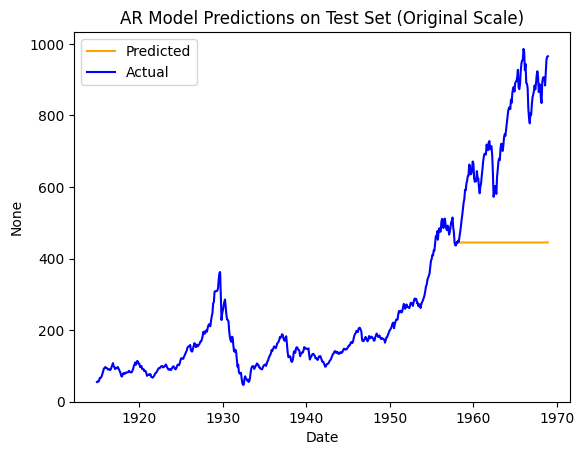

In [143]:
# Convert x_pred back to original scale via differencing
y_pred = (
    X_pred + dowjones_df.Price.iloc[int(len(X) * 0.8) - 1]
)  # Adding the last known value from the training set
y_pred = pd.Series(y_pred, index=dowjones_df.index[int(len(X) * 0.8) :])

sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=y_pred, color="orange", label="Predicted")
sns.lineplot(x=dowjones_df.index, y=dowjones_df.Price, color="blue", label="Actual")
plt.title("AR Model Predictions on Test Set (Original Scale)")
plt.legend()
plt.show()

## **ARIMA**

ARMA is a combination of the Auto-Regressive and Moving Average models for forecasting. This model provides a weakly stationary stochastic process in terms of two polynomials, one for the Auto-Regressive and the second for the Moving Average.

ARMA is best for predicting stationary series. 

ARIMA stands for Autoregressive Integrated Moving Average, which is a popular model in a linear model family, that utilizes historical values to forecast future values. ARIMA consists of three key components called $(p,d,q)$. To use ARIMA, It is suggested to work with stationary data (we did differencing).

ARIMA was thus developed to support both stationary as well as non-stationary series.

- AR: Uses past values to predict the future.
- MA: Uses past error terms in the given series to predict the future.
- I: Uses the differencing of observation and makes the stationary data.

![images](images/arima.png)

Determining the optimal value of $(p,d,q)$ needs to be utilized in various techniques for each. Remember we already determined the value for $d$. For determining the value of $(p)$, we will use the concept of Autocorrelation and Partial Autocorrelation function plots.

![image](images/arima_explained.png)

So, using PACF and ACF, we try to find the answer for ARIMA as

- ACF asks: Does today’s passenger number influence tomorrow’s, or even the day after tomorrow’s?
- PACF asks: If we ignore tomorrow’s passenger count, does today’s passenger count directly affect the day after tomorrow’s count?

### **statsmodels.tsa.ARIMA**

In [144]:
X = dowjones_df.Price.fillna(0).values
y = dowjones_df.Price.values

# Split into train and test sets
X_train, X_test = X[: int(len(X) * 0.8)], X[int(len(X) * 0.8) :]
y_train, y_test = y[: int(len(y) * 0.8)], y[int(len(y) * 0.8) :]

In [145]:
import statsmodels.api as sm

best_aic = float("inf")
best_order = None
max_p = 4
max_q = 4
d = 2  # Differencing order

for p in range(max_p + 1):
    for q in range(max_q + 1):
        try:
            model = sm.tsa.ARIMA(X_train, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [146]:
print(f"Best model order: {best_order} with AIC: {best_aic}")

Best model order: (2, 2, 4) with AIC: 3659.194409088481


In [147]:
model = sm.tsa.ARIMA(X_train, order=(2, 2, 4))

In [148]:
# Fit the model to the data
model_fit = model.fit()

In [149]:
# View the summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  519
Model:                 ARIMA(2, 2, 4)   Log Likelihood               -1822.597
Date:                Fri, 04 Jul 2025   AIC                           3659.194
Time:                        13:50:09   BIC                           3688.931
Sample:                             0   HQIC                          3670.846
                                - 519                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3266      0.093     -3.509      0.000      -0.509      -0.144
ar.L2         -0.7970      0.082     -9.765      0.000      -0.957      -0.637
ma.L1         -0.3068      0.092     -3.336      0.0

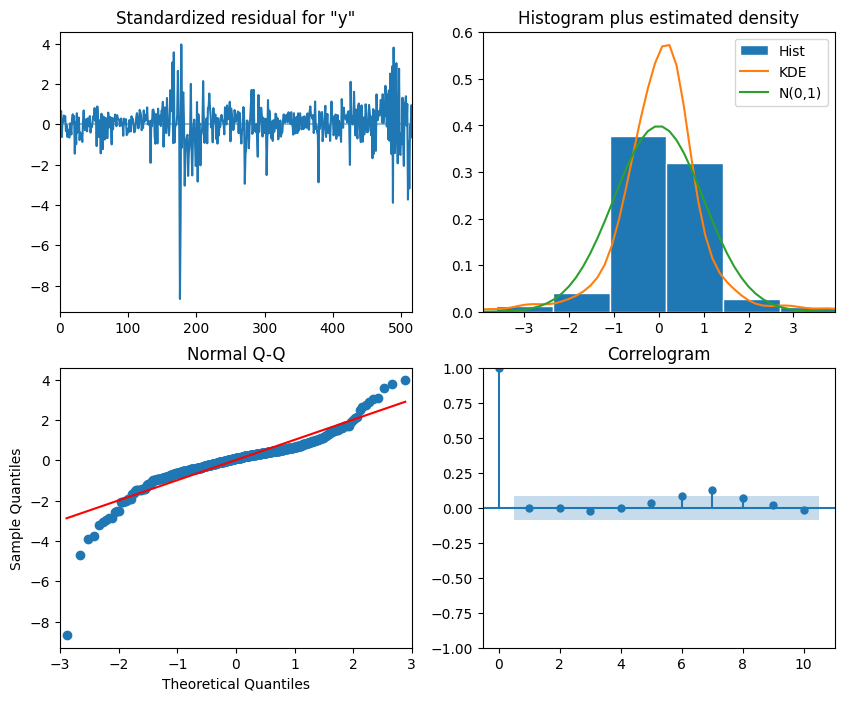

In [150]:
# Plot the diagnostic charts for the model
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [151]:
# Forecast for the next 12 months
forecast_arima = model_fit.forecast(steps=12)
forecast_arima

array([443.39769683, 443.8015772 , 445.41523676, 446.8257332 ,
       447.33845374, 448.30633559, 449.84102858, 450.82783601,
       451.54188312, 452.78166382, 454.06709586, 454.91863137])

In [152]:
# Show forecast
model_fit.get_forecast(steps=12).summary_frame(alpha=0.05)

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,443.397697,8.183172,427.358974,459.436420
1,443.801577,13.858048,416.640303,470.962852
2,445.415237,17.957026,410.220112,480.610362
3,446.825733,20.945405,405.773494,487.877972
4,447.338454,23.613526,401.056793,493.620115
5,448.306336,26.253182,396.851045,499.761626
6,449.841029,28.578360,393.828473,505.853584
7,450.827836,30.621477,390.810845,510.844828
8,451.541883,32.653631,387.541942,515.541824
9,452.781664,34.640390,384.887746,520.675581


In [153]:
# Predict on test set
X_pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)

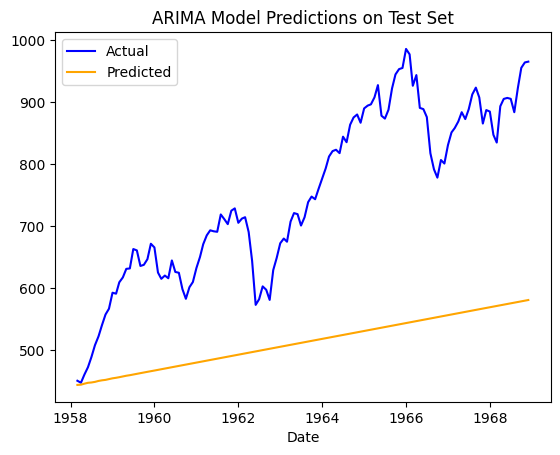

In [154]:
# Plot predictions
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_test, color="blue", label="Actual")
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_pred, color="orange", label="Predicted")
plt.title("ARIMA Model Predictions on Test Set")
plt.legend()
plt.show()

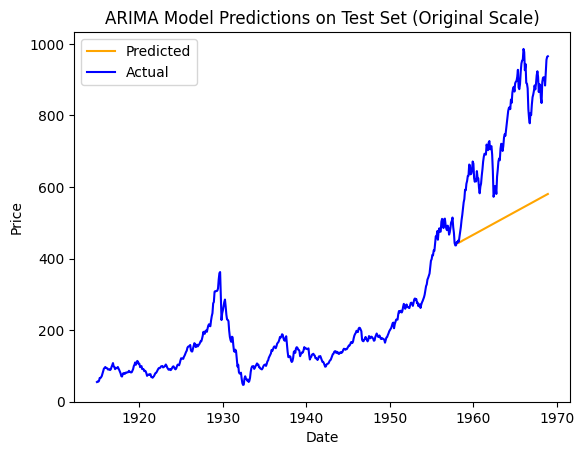

In [155]:
# Convert x_pred back to original scale via log transformation
y_pred = X_pred  # Inverse of log transformation

sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=y_pred, color="orange", label="Predicted")
sns.lineplot(x=dowjones_df.index, y=dowjones_df.Price, color="blue", label="Actual")
plt.title("ARIMA Model Predictions on Test Set (Original Scale)")
plt.legend()
plt.show()

## **SARIMA** 

SARIMA is the same as ARIMA with concern of seasonality so it is called Seasonal-ARIMA. In other words, we can say, that it is an extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns.

As ARIMA is composed of 3 components — autoregressive (AR), integrated (I), and moving average (MA)), SARIMA is extended with a 4th component called seasonal components, which refers to repeating patterns in the data. This could be daily, monthly, yearly, or any other regular interval.

![image](images/sarima.png)

Similar to ARIMA, the P, D, Q values for seasonal parts of the model can be deduced from the ACF and PACF plots of the data same as the previously used concept.

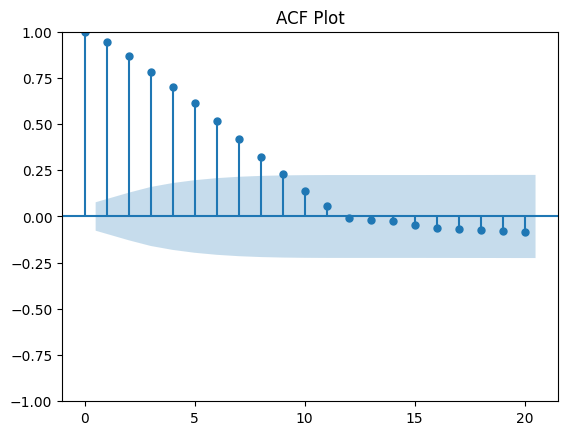

In [156]:
plot_acf(dowjones_df.Price_diff_12.fillna(0), lags=20)
plt.title("ACF Plot")
plt.show()

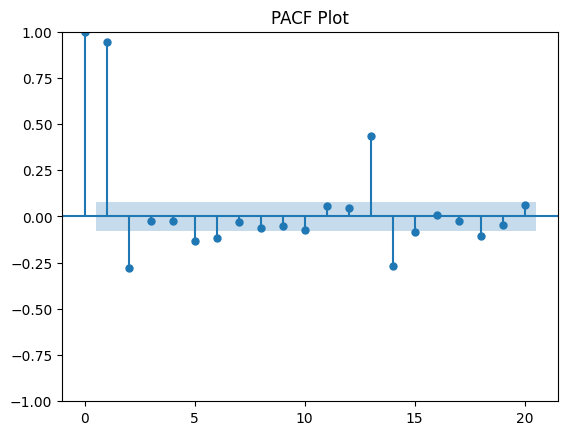

In [157]:
plot_pacf(dowjones_df.Price_diff_12.fillna(0), lags=20)
plt.title("PACF Plot")
plt.show()

### **statsmodels.tsa.SARIMAX**

In [93]:
import statsmodels.api as sm

best_aic = float("inf")
best_order = None
best_seasonal_order = None
d = 2
D = 2

for p in range(3):  # Test p = 0, 1, 2
    for q in range(3):  # Test q = 0, 1, 2
        for P in range(3):  # Test P = 0, 1, 2
            for Q in range(3):  # Test Q = 0, 1, 2
                try:
                    model = sm.tsa.SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, 12))
                    result = model.fit(disp=False)
                    if result.aic < best_aic:
                        best_aic = result.aic
                        best_order = (p, d, q)
                        best_seasonal_order = (P, D, Q, 12)
                except:
                    continue

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\base\mo

In [94]:
print(f"Best order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

Best order: (0, 2, 1)
Best seasonal order: (2, 2, 2, 12)


In [159]:
import statsmodels.api as sm

# Build a seasonal ARIMA model for the time series
model = sm.tsa.SARIMAX(
    X_train,
    order=(1, 2, 1),
    seasonal_order=(2, 2, 2, 12),
)
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  519
Model:             SARIMAX(1, 2, 1)x(2, 2, [1, 2], 12)   Log Likelihood               -1818.297
Date:                                 Fri, 04 Jul 2025   AIC                           3650.593
Time:                                         13:50:32   BIC                           3679.997
Sample:                                              0   HQIC                          3662.138
                                                 - 519                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3287      0.019     17.502      0.000       0.292       0

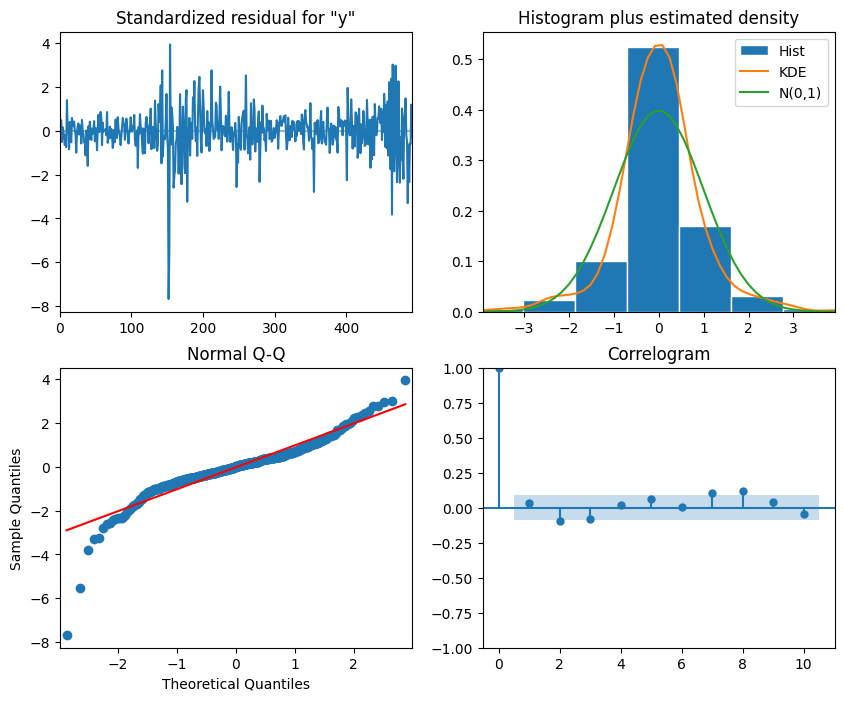

In [160]:
# Plot the diagnostic charts for the model
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [161]:
# Predict on test set
X_pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)

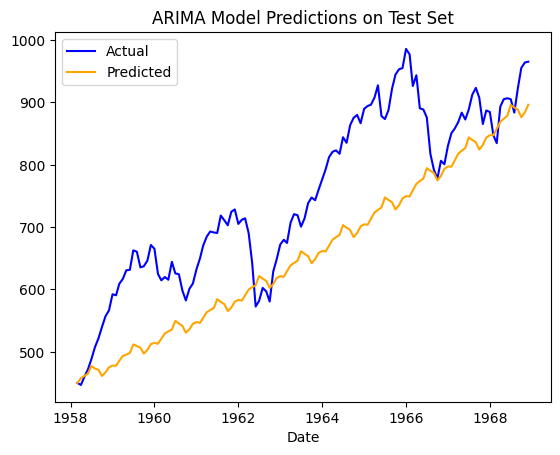

In [162]:
# Plot predictions
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_test, color="blue", label="Actual")
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_pred, color="orange", label="Predicted")
plt.title("ARIMA Model Predictions on Test Set")
plt.legend()
plt.show()

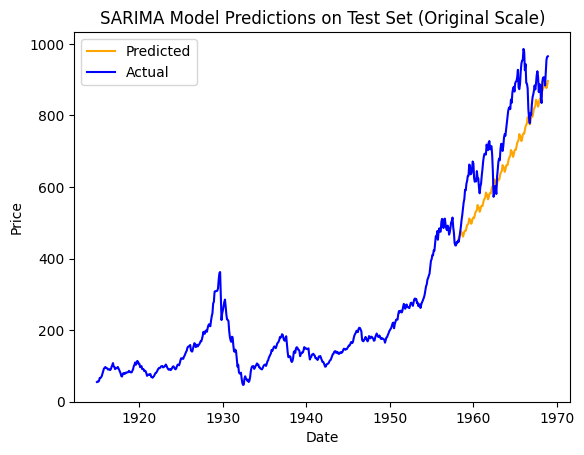

In [163]:
# Convert x_pred back to original scale via log transformation
y_pred = X_pred  # Inverse of log transformation

sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=y_pred, color="orange", label="Predicted")
sns.lineplot(x=dowjones_df.index, y=dowjones_df.Price, color="blue", label="Actual")
plt.title("SARIMA Model Predictions on Test Set (Original Scale)")
plt.legend()
plt.show()

Now, let's compare ARIMA and SARIMA and see which is better. Looking at performance for ARIMA and SARIMA. For this, we will look into MAE, MSE, RMSE AIC, and BIC.

Based on this we can say, that SARIMA is better. Let's see visually also. To do so we plotted Actual vs Predicted for SARIMA

In [164]:
# Adding the predicted values from ARIMA model to the dataset
dowjones_df["Price_SARIMA"] = model_fit.predict(start=0, end=len(dowjones_df) - 1)

# Creating a DataFrame that contains both actual and predicted values
actual_vs_predicted_arima_df = dowjones_df[["Price", "Price_SARIMA"]]

# Display the DataFrame to check the actual vs predicted values
actual_vs_predicted_arima_df.head()

# Plot actual vs predicted values for ARIMA
fig_arima = go.Figure()

# Add actual passenger data
fig_arima.add_trace(
    go.Scatter(
        x=dowjones_df.index,
        y=dowjones_df["Price"],
        mode="lines",
        name="Actual",
        line=dict(color="blue"),
    )
)

# Add predicted passenger data (ARIMA)
fig_arima.add_trace(
    go.Scatter(
        x=dowjones_df.index,
        y=dowjones_df["Price_SARIMA"],
        mode="lines",
        name="Predicted",
        line=dict(dash="dash", color="red"),
    )
)

# Update layout
fig_arima.update_layout(
    title="Actual vs Predicted", xaxis_title="Date", yaxis_title="Price", legend_title="Data"
)

# Show plot
fig_arima.show()

## **Exponential Smoothing** 

Exponential smoothing is a widely used and effective method for time series forecasting that can provide accurate predictions while being computationally efficient.

Exponential smoothing is a statistical technique that uses past observations of a time series to forecast its future values. It is called “exponential” because it assigns exponentially decreasing weights to past observations, with more recent observations having higher weights than older ones. This makes the method adaptive, as it automatically adjusts the weights based on the data, capturing any underlying patterns or trends.

There are several types of exponential smoothing methods, including simple exponential smoothing (SES), double exponential smoothing (DES), and triple exponential smoothing (TES), also known as the Holt-Winters method. Let’s take a closer look at each of them.

The choice of which type of exponential smoothing method to use depends on the characteristics of the time series data and the specific forecasting requirements.

1. Simple Exponential Smoothing (SES): SES is suitable for time series data that has no trend or seasonality and exhibits a stable level over time. It is a basic method that can be used when the data does not show any systematic patterns or irregularities, and a simple forecast based on the most recent observation and the previous forecast is desired. SES is computationally efficient and easy to implement, making it suitable for real-time forecasting or situations where data availability is limited.
2. Double Exponential Smoothing (DES): DES is suitable for time series data that exhibit a trend, i.e., a systematic change in the time series values over time. It is an extension of SES that incorporates a trend component in addition to the level component, allowing for capturing trend patterns in the data. DES is useful when the data shows a consistent upward or downward trend and a forecast that considers both the current level and the trend is needed. DES is also appropriate when the data has no seasonality, but exhibits a trend.
3. Triple Exponential Smoothing (TES): TES is suitable for time series data that exhibits both trend and seasonality. It is an extension of DES that incorporates a seasonal component in addition to the level and trend components, allowing for capturing seasonal patterns in the data. TES is useful when the data shows both a trend and a repeating pattern in the values over time, such as monthly or quarterly seasonality. TES can provide forecasts that consider the current level, trend, and seasonality of the data, making it suitable for forecasting in situations where both trend and seasonality are present.

However, exponential smoothing also has some limitations. It may not perform well for time series data with complex patterns or irregularities, such as sudden changes in the level or trend, outliers, or abrupt shifts in the seasonality. In such cases, other advanced forecasting methods may be more appropriate. 

### **Simple Exponential Smoothing (SES)**

SES is the most basic form of exponential smoothing. It uses only the current observation and the forecast from the previous period to make the next forecast. The formula for simple exponential smoothing is:

$F(t+1) = \alpha Y(t) + (1 — \alpha) F(t)$

where $F(t+1)$ is the forecast for the next period, $Y(t)$ is the actual observation at time $t$, $F(t)$ is the forecast for the current period. A smaller value of $\alpha$ gives more weight to the past observations, while a larger value of $\alpha$ gives more weight to the current observation.

In [166]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 1. Simple Exponential Smoothing (SES) - No Trend, No Seasonality
model = SimpleExpSmoothing(dowjones_df["Price"], initialization_method="estimated")
# Fit the model to the data
model_fit = model.fit(smoothing_level=0.2, optimized=False)
# View the summary of the model
print(model_fit.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Price   No. Observations:                  649
Model:             SimpleExpSmoothing   SSE                         440552.937
Optimized:                      False   AIC                           4235.709
Trend:                           None   BIC                           4244.660
Seasonal:                        None   AICC                          4235.771
Seasonal Periods:                None   Date:                 Fri, 04 Jul 2025
Box-Cox:                        False   Time:                         13:51:16
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2000000                alpha                False
initial_level              48.243333                

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [167]:
dowjones_df["SES"] = model_fit.fittedvalues

In [168]:
# Predict on test set
X_pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1)

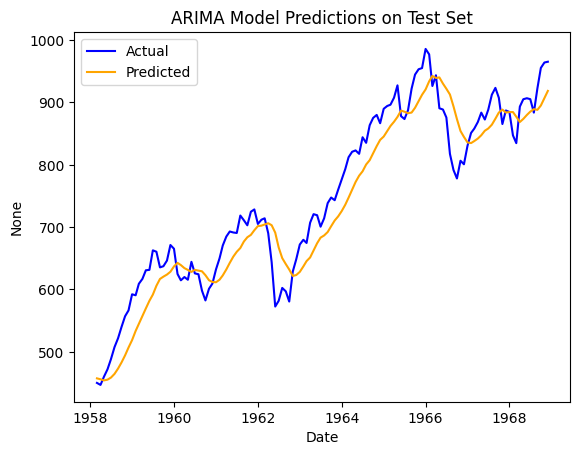

In [169]:
# Plot predictions
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_test, color="blue", label="Actual")
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_pred, color="orange", label="Predicted")
plt.title("ARIMA Model Predictions on Test Set")
plt.legend()
plt.show()

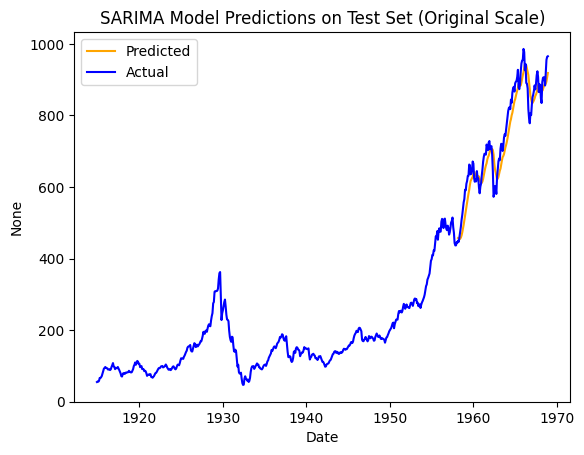

In [170]:
# Convert x_pred back to original scale via log transformation
y_pred = X_pred  # Inverse of log transformation

sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=y_pred, color="orange", label="Predicted")
sns.lineplot(x=dowjones_df.index, y=dowjones_df.Price, color="blue", label="Actual")
plt.title("SARIMA Model Predictions on Test Set (Original Scale)")
plt.legend()
plt.show()

### **Double Exponential Smoothing (DES)**

DES extends simple exponential smoothing by incorporating a trend component and the level component. It is suitable for time series data that exhibit a trend, i.e., a systematic change in the time series values over time.  Double exponential smoothing uses two smoothing parameters, α for the level and β for the trend, allowing for greater flexibility in capturing different patterns in the data.

In [171]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 2. Double Exponential Smoothing (DES) - Trend, No Seasonality
model = ExponentialSmoothing(
    dowjones_df["Price"],
    trend="add",
    initialization_method="estimated",
)
# Fit the model to the data
model_fit = model.fit(smoothing_level=0.2, smoothing_trend=0.1, optimized=False)
# View the summary of the model
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  649
Model:             ExponentialSmoothing   SSE                         424673.164
Optimized:                        False   AIC                           4215.884
Trend:                         Additive   BIC                           4233.786
Seasonal:                          None   AICC                          4216.015
Seasonal Periods:                  None   Date:                 Fri, 04 Jul 2025
Box-Cox:                          False   Time:                         13:51:28
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2000000                alpha                False
smoothing_trend            0.10000

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [172]:
# Predict on test set
X_pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1)

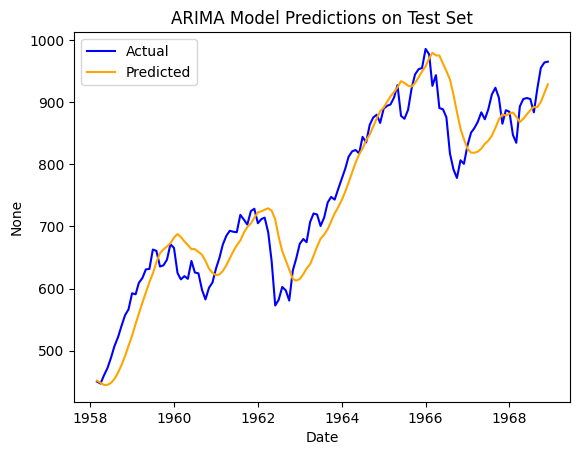

In [173]:
# Plot predictions
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_test, color="blue", label="Actual")
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_pred, color="orange", label="Predicted")
plt.title("ARIMA Model Predictions on Test Set")
plt.legend()
plt.show()

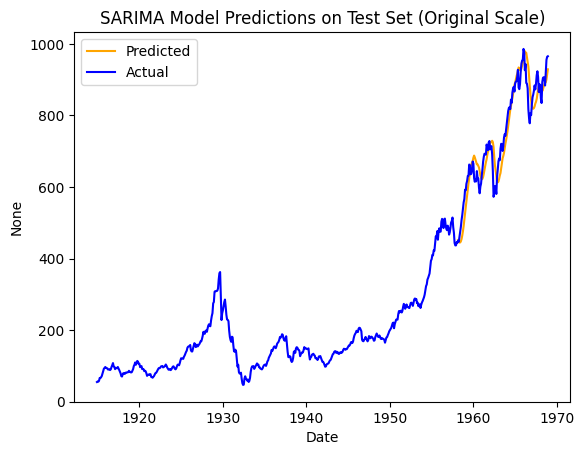

In [174]:
# Convert x_pred back to original scale via log transformation
y_pred = X_pred  # Inverse of log transformation

sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=y_pred, color="orange", label="Predicted")
sns.lineplot(x=dowjones_df.index, y=dowjones_df.Price, color="blue", label="Actual")
plt.title("SARIMA Model Predictions on Test Set (Original Scale)")
plt.legend()
plt.show()

### **Triple Exponential Smoothing (TES)**

TES extends the double exponential smoothing by also incorporating a seasonal component in addition to the level and trend components. It is suitable for time series data that exhibits seasonality, i.e., a repeating pattern in the time series values over time.

In [175]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 3. Triple Exponential Smoothing (TES) - Trend, Seasonality
model = ExponentialSmoothing(
    dowjones_df["Price"],
    trend="add",
    seasonal="add",
    initialization_method="estimated",
)
# Fit the model to the data
model_fit = model.fit(
    smoothing_level=0.2, smoothing_trend=0.1, smoothing_seasonal=0.1, optimized=False
)
# View the summary of the model
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  649
Model:             ExponentialSmoothing   SSE                         431252.506
Optimized:                        False   AIC                           4249.862
Trend:                         Additive   BIC                           4321.469
Seasonal:                      Additive   AICC                          4250.947
Seasonal Periods:                    12   Date:                 Fri, 04 Jul 2025
Box-Cox:                          False   Time:                         13:51:40
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha                False
smoothing_trend          

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [176]:
# Predict on test set
X_pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1)

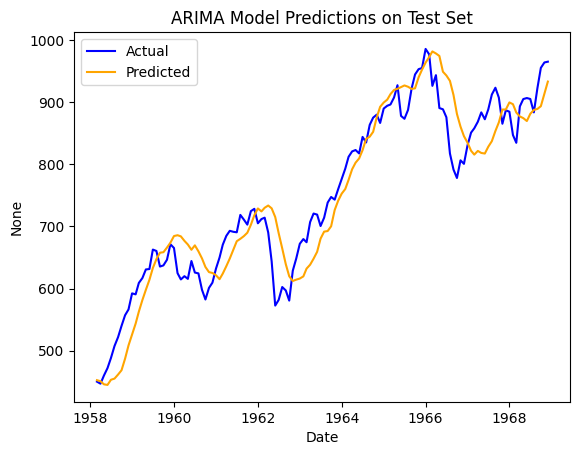

In [177]:
# Plot predictions
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_test, color="blue", label="Actual")
sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=X_pred, color="orange", label="Predicted")
plt.title("ARIMA Model Predictions on Test Set")
plt.legend()
plt.show()

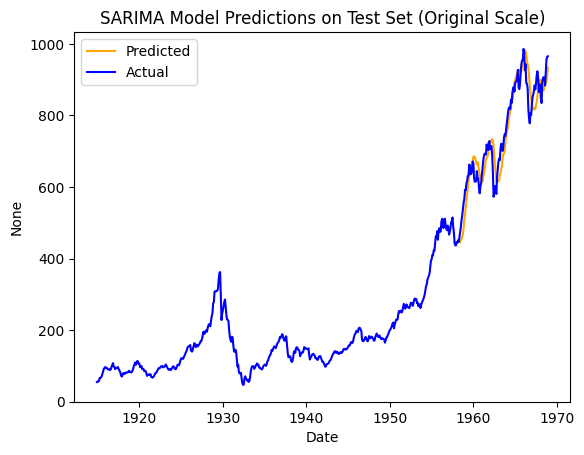

In [178]:
# Convert x_pred back to original scale via log transformation
y_pred = X_pred  # Inverse of log transformation

sns.lineplot(x=dowjones_df.index[int(len(X) * 0.8) :], y=y_pred, color="orange", label="Predicted")
sns.lineplot(x=dowjones_df.index, y=dowjones_df.Price, color="blue", label="Actual")
plt.title("SARIMA Model Predictions on Test Set (Original Scale)")
plt.legend()
plt.show()

## **Vector Autoregression (VAR)**

A VAR model is a statistical model that describes the joint behavior of multiple time series variables based on their lagged values. Unlike traditional time series models, such as autoregressive (AR) or moving average (MA) models, VAR models allow for the simultaneous analysis of the interdependencies among several variables. VAR models are widely used in macroeconomics, finance, and other disciplines to analyze systems with multiple interrelated variables.

In the realm of econometrics and time series analysis, the Vector Autoregressive (VAR) model stands as a powerful tool for understanding and forecasting the dynamic interrelationships among multiple variables. VAR models have gained significant popularity due to their ability to capture complex interactions between variables, providing insights into the behavior of economic systems, financial markets, and other dynamic processes. This article aims to provide a detailed understanding of VAR models, their construction, estimation, and interpretation.

A VAR model consists of a set of equations, where each equation represents one variable as a function of its own lagged values and the lagged values of other variables in the system. The key assumptions of a VAR model are stationarity, linearity, and a constant covariance matrix of the error terms. Additionally, VAR models assume that variables in the system have a contemporaneous effect on each other, capturing the dynamic interactions within the system.

### **Granger’s Causality Test**

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

```python
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   
```

So how to read the above output?

The row are the Response (Y) and the columns are the predictor series (X). For example, if you take the value 0.0003 in (row 1, column 2), it refers to the p-value of pgnp_x causing rgnp_y. Whereas, the 0.000 in (row 2, column 1) refers to the p-value of rgnp_y causing pgnp_x.

So, how to interpret the p-values?

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). For example, P-Value of 0.0003 at (row 1, column 2) represents the p-value of the Grangers Causality test for pgnp_x causing rgnp_y, which is less that the significance level of 0.05.

So, you can reject the null hypothesis and conclude pgnp_x causes rgnp_y.

Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other. This makes this system of multi time series a good candidate for using VAR models to forecast.

### **Cointegration Test**

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series. But, what does Cointegration mean?

To understand that, you first need to know what is ‘order of integration’ (d). Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary. Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated. Ok?

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship. This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.

Alright, So how to do this test? Soren Johanssen in his paper (1991) devised a procedure to implement the cointegration test. It is fairly straightforward to implement in python’s statsmodels, as you can see below.

```python
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)
```

### **ADF**

To test for stationarity, we employed the Augmented Dickey-Fuller (ADF) test. This test helps us determine whether each time series in our dataset (electricity prices, gas prices, temperature, etc.) contains a unit root, indicating non-stationarity.

| Time Series | ADF Statistic | p-value | Stationarity Conclusion |
|--------------------------|----------------|----------|--------------------------|
| Electricity Price (MWh) | -3.02 | 0.03 | Stationary (Reject Null) |
| Gas Price (MWh) | -1.39 | 0.59 | Non-Stationary (Fail to Reject) |
| Temperature | -1.85 | 0.35 | Non-Stationary (Fail to Reject) |
| Rain | -11.71 | 0.00 | Stationary (Reject Null) |
| Snowfall | -7.78 | 0.00 | Stationary (Reject Null) |
| Cloudcover Total | -3.89 | 0.00 | Stationary (Reject Null) |
| Cloudcover Mid | -14.07 | 0.00 | Stationary (Reject Null) |
| Cloudcover High | -15.10 | 0.00 | Stationary (Reject Null) |
| Shortwave Radiation | -1.46 | 0.55 | Non-Stationary (Fail to Reject) |


```python
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   
         
# Call the adfuller_test() on each series.

# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')
```

The ADF test results reveal that while some series like electricity prices and certain weather variables are stationary, others like gas prices and temperature are not. Non-stationary series exhibit trends or other characteristics that change over time, making them unsuitable for direct use in VAR modeling. For these series, we’ll need to apply techniques such as differencing or decomposition to remove trends and stabilize their statistical properties. Once transformed into a stationary form, these series can then be retested and potentially included in the VAR model.

After the first difference, Real Wages (Manufacturing) is still not stationary. It’s critical value is between 5% and 10% significance level. All of the series in the VAR model should have the same number of observations. So, we are left with one of two choices. That is, either proceed with 1st differenced series or difference all the series one more time.

### **Exponential Smoothing**

In this section, we address the challenge of transforming our non-stationary time series data into a form that’s more suitable for VAR modeling. We focus on making the series for electricity prices, gas prices, temperature, and shortwave radiation stationary. To achieve this, we employ Holt’s Linear Trend method, which is a powerful tool for smoothing time series data.

Holt-Winters Exponential Smoothing (HWES) is not a method designed to make a time series stationary. Instead, it is a forecasting technique that accounts for trend and seasonality by applying exponential smoothing. However, Holt-Winters can help stabilize fluctuations, which might indirectly make a series closer to stationary, but it does not remove trends or seasonality permanently like differencing.

```python
from statsmodels.tsa.holtwinters import Holt

model = Holt(dowjones_df["Price"])
results = model.fit(smoothing_level=0.1)
trend = results.fittedvalues
level = results.level
residual = dowjones_df["Price"] - trend
```

We choose a `smoothing_level` of 0.1 to ensure that the level component of our series is smoothed out significantly. This choice is deliberate as it allows us to focus on long-term trends rather than short-term fluctuations. By doing so, we mitigate the impact of short-term volatility and emphasize the underlying trend in each time series.

Furthermore, we calculate the residual of each series as the difference between the actual values and their respective estimated trends. The rationale behind this is twofold: firstly, residuals often exhibit stationary characteristics, making them more appropriate for VAR modeling. Secondly, in future steps, we intend to forecast both the trend and residual components separately and then combine these forecasts to construct the prediction for the main time series. This approach enables us to capture both the underlying trend and the random fluctuations inherent in the time series data.

In VAR (Vector Autoregression) modeling, determining the correct order (number of lags) is crucial for the model’s accuracy and efficiency. The order of a VAR model indicates the number of previous time points (lags) used to predict the current value in the series. An appropriately chosen lag order captures the essential dynamics of the system without overfitting the data.

To determine the optimal lag order, we often rely on information criteria such as the Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), or the Hannan-Quinn Information Criterion (HQIC). These criteria balance model complexity (number of lags) with goodness of fit, with lower values indicating a better model.

### **statsmodels.tsa.api.VAR**

```python
import pandas as pd
from statsmodels.tsa.api import VAR

data_for_var = pd.concat([total_data[['rain','snowfall', 'cloudcover_total', 'cloudcover_mid', 'cloudcover_high']],
                           electricity_price_residual, gas_price_residual, temperature_residual, radiation_residual], axis=1, join='inner')

# Fitting a VAR model
model = VAR(data_for_var)

# Determining the optimal lag order
lag_order_results = model.select_order(maxlags=10)
print(lag_order_results.summary())
```

In [ ]:
# VAR Order Selection (* highlights the minimums)
# ==================================================
#        AIC         BIC         FPE         HQIC
# --------------------------------------------------
# 0        30.26       30.32   1.387e+13       30.29
# 1        26.99      27.63*   5.258e+11      27.24*
# 2       26.94*       28.16  5.037e+11*       27.42
# 3        27.03       28.82   5.502e+11       27.73
# 4        27.12       29.48   5.997e+11       28.03
# 5        27.18       30.11   6.381e+11       28.32
# 6        27.24       30.75   6.797e+11       28.60
# 7        27.32       31.40   7.409e+11       28.91
# 8        27.38       32.04   7.869e+11       29.19
# 9        27.50       32.73   8.898e+11       29.53
# 10       27.59       33.39   9.763e+11       29.84
# --------------------------------------------------

After determining the optimal lag order for our VAR model, the next step is to estimate the VAR model itself. This involves fitting the model to our time series data with the chosen lag order. Estimation of a VAR model provides us with the coefficients that describe the relationships between each pair of time series in the system. These coefficients are essential for understanding how changes in one variable affect others and for forecasting future values of the time series.

```python
# Assuming 'data_for_var' contains the relevant time series data
model = VAR(data_for_var)

# Fitting the model with the chosen lag order
model_fitted = model.fit(2, ic='aic', trend='ct')

# model_fitted.summary()
```

After estimating the model and ensuring it passes diagnostic checks, we can use it to predict future values of the included variables.

```python
# Forecasting
forecast_steps = 10  # Number of steps to forecast ahead
forecast = model_fitted.forecast(model_fitted.endog, steps=forecast_steps)

forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=data_for_var.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=data_for_var.columns)

# Concatenate the predicted and last 50 observations of historical data for 'electricity_price_residual'
concatenated_data = pd.concat([data_for_var['electricity_price_residual'].tail(50), forecast_df['electricity_price_residual']])

# Plot the concatenated data
plt.figure(figsize=(12, 6))
plt.plot(data_for_var.index[-50:], data_for_var['electricity_price_residual'].tail(50), label='Historical', color='blue',marker = 'o')
plt.plot(forecast_df.index, forecast_df['electricity_price_residual'], label='Forecast', color='orange',marker = '*')
plt.title('Historical and Predicted Electricity Price Residual')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
```

In our analysis, we’ve decomposed the electricity price time series into trend and residual components. We’ve already forecasted the residual component using a VAR model. To construct a comprehensive forecast of the electricity price, we now turn to predicting the trend component. For the trend, we’ll use a simpler approach: polynomial fitting. This method is effective for capturing the underlying trend in a time series, especially over a short horizon. By combining forecasts from these two distinct components — the trend and the residual — we can reconstruct a more nuanced and potentially more accurate forecast of the original electricity price series.

```python
electricity_price = total_data['electricity_price_per_mwh']

# the fitted Holt model 
electricity_price_model = Holt(total_data['electricity_price_per_mwh'])
electricity_price_results = electricity_price_model.fit(smoothing_level=0.1)
electricity_price_trend = electricity_price_results.fittedvalues
electricity_price_level = electricity_price_results.level
electricity_price_residual = total_data['electricity_price_per_mwh'] - electricity_price_trend


# Forecasting the trend component
forecast_steps = 10  # Number of steps to forecast ahead

# Forecasting future trend values
electricity_price_trend_forecast = electricity_price_results.forecast(steps=forecast_steps)

# Creating a date range for the forecast
electricity_price_trend_forecast_index = pd.date_range(start=electricity_price_trend.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Creating a DataFrame for the forecasted trend
electricity_price_trend_forecast_df = pd.DataFrame(electricity_price_trend_forecast, index=electricity_price_trend_forecast_index, columns=['electricity_price_trend_forecast'])

# sum the predicted trend and predicted residual values to get the final forecast
forecast_df['electricity_price_residual_final'] = forecast_df['electricity_price_residual'] + electricity_price_trend_forecast_df['electricity_price_trend_forecast']


# Plotting the final forecast of original electricity_price
plt.figure(figsize=(12, 6))
plt.plot(electricity_price[-100:], label='Historical', color='blue')
plt.plot(forecast_df.index, forecast_df['electricity_price_residual_final'], label='Forecast', color='orange', marker='*')
plt.title('Historical and Predicted Electricity Price')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
```

# **Extra Reading**

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://medium.com/dataman-in-ai/tree-based-xgb-lightgbm-and-catboost-models-for-multi-period-time-series-probabilistic-6b12d1500779

https://pub.towardsai.net/a-generalized-machine-learning-framework-for-time-series-forecasting-54f839546d9e

https://medium.com/dataman-in-ai/monte-carlo-simulation-for-time-series-probabilistic-forecasts-e04a7d29c9b3

https://medium.com/data-science-collective/a-unified-machine-learning-framework-for-time-series-forecasting-7f3971216ec1

https://levelup.gitconnected.com/anomaly-detection-in-time-series-data-with-python-5a15089636db

https://medium.com/data-science/how-to-forecast-time-series-data-using-any-supervised-learning-model-02dd62cd4bda

https://medium.com/dataman-in-ai/conformal-predictions-for-time-series-probabilistic-forecasting-2a892377bd5c

https://medium.com/@ajayverma23/unlocking-the-secrets-of-time-a-deep-dive-into-time-series-analysis-c96181621d9a

https://medium.com/coding-nexus/probabilistic-forecasting-with-skforecast-a-python-adventure-ba51f5aa21a7

https://medium.com/data-science/forecast-time-series-with-missing-values-beyond-linear-interpolation-2f2adf0a0cba

https://medium.com/the-forecaster/timexer-for-time-series-forecasting-with-exogenous-features-f364c113da62

https://medium.com/data-science-collective/hands-on-multivariate-analysis-and-mlp-for-price-forecasting-pt-i-fcf74d14f5e6

https://medium.com/data-science-collective/hands-on-irregular-time-series-for-predictive-modeling-part-ii-e5070e721bd6

https://kaabar-sofien.medium.com/machine-learning-in-finance-mastering-time-series-classification-with-random-forests-773acc3cca71

https://medium.com/data-science/hands-on-monotonic-time-series-forecasting-with-xgboost-using-python-ebcd2c27f9e6

https://medium.com/data-science/12-ways-to-test-your-forecasts-like-a-pro-a783016c2515

https://medium.com/code-applied/time-series-secrets-decomposition-of-a-time-series-af754db07d79

https://medium.com/@kylejones_47003/boosting-stacking-and-bagging-for-ensemble-models-for-time-series-analysis-with-python-d74ab9026782

https://medium.com/data-science-collective/hands-on-irregular-time-series-pt-i-2b8730bff40b

https://medium.com/@ericbrownaustin/time-series-prediction-with-autogluon-451bc64f303a

https://medium.com/data-science-collective/18-libraries-for-time-series-feature-extraction-f12fd1bae738

https://medium.com/@kylejones_47003/cross-validation-for-time-series-data-51fd11c38e2b

https://medium.com/data-science/how-to-forecast-time-series-using-lags-5876e3f7f473